In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import MeCab
import random
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import warnings
import math
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv('/home/tanaka/Archive/NN_dataset.csv')
df.columns

Index(['試合ID', '攻撃履歴No', 'チームID', '選手ID', '選手名', 'チーム名', 'F_成功', '縦位置_1',
       '縦位置_2', '縦位置_3', '縦位置_4', '縦位置_5', '縦位置_6', '横位置_1', '横位置_2', '横位置_3',
       '横位置_4', '方向8_前', '方向8_右', '方向8_右前', '方向8_右後', '方向8_左', '方向8_左前',
       '方向8_左後', '方向8_後', 'タッチ種別_0', 'タッチ種別_1', 'タッチ種別_2', 'タッチ種別_3',
       'F_セットプレー', 'F_セットプレー中', 'F_ゴール', 'F_シュート', 'F_ミスヒット', 'F_アシスト',
       'F_シュートアシスト', 'F_パス', 'F_クロス', 'F_スルーパス', 'F_フリックオン', 'F_フィード',
       'F_パス受け', 'F_トラップ', 'F_ドリブル', 'F_ペナルティエリア進入', 'F_ペナルティ脇進入',
       'F_30mライン進入', 'F_こぼれ球奪取', 'F_クリア', 'F_インターセプト', 'F_ブロック', 'F_タックル',
       '空中戦F', 'F_キャッチ', 'F_ファンブル', 'F_ハンドクリア', 'F_ゴールキック', 'F_コーナーキック',
       'F_直接フリーキック', 'F_間接フリーキック', 'F_ペナルティキック', 'F_スローイン', 'F_ファウル',
       'F_PK与えた', 'F_被ファウル', 'F_オフサイド', 'F_イエローカード', 'F_レッドカード', 'F_タッチ',
       'F_ポスト・バー', 'comment', 'comment_golden', '部位ID_-1.0', '部位ID_0.0',
       '部位ID_1.0', '部位ID_2.0', '部位ID_3.0', '部位ID_4.0', 'ポジションID_-1.0',
       'ポジションID_0.0', 'ポジションID_1.0', 'ポジションID_2.0', 'ポジション

In [2]:
use_columns = df.columns
drop_columns = ['試合ID','攻撃履歴No','チームID','選手ID','選手名','チーム名','comment','comment_golden']
column_length = len(use_columns) - len(drop_columns)
aa = len(df['comment'].unique())
print(f'あつかうPlay_Dataの大きさ:{df.shape}')
print(f'\nデータのペアの数:{aa}')
print(df.columns.tolist())  # リスト形式で出力

あつかうPlay_Dataの大きさ:(19938, 84)

データのペアの数:1520
['試合ID', '攻撃履歴No', 'チームID', '選手ID', '選手名', 'チーム名', 'F_成功', '縦位置_1', '縦位置_2', '縦位置_3', '縦位置_4', '縦位置_5', '縦位置_6', '横位置_1', '横位置_2', '横位置_3', '横位置_4', '方向8_前', '方向8_右', '方向8_右前', '方向8_右後', '方向8_左', '方向8_左前', '方向8_左後', '方向8_後', 'タッチ種別_0', 'タッチ種別_1', 'タッチ種別_2', 'タッチ種別_3', 'F_セットプレー', 'F_セットプレー中', 'F_ゴール', 'F_シュート', 'F_ミスヒット', 'F_アシスト', 'F_シュートアシスト', 'F_パス', 'F_クロス', 'F_スルーパス', 'F_フリックオン', 'F_フィード', 'F_パス受け', 'F_トラップ', 'F_ドリブル', 'F_ペナルティエリア進入', 'F_ペナルティ脇進入', 'F_30mライン進入', 'F_こぼれ球奪取', 'F_クリア', 'F_インターセプト', 'F_ブロック', 'F_タックル', '空中戦F', 'F_キャッチ', 'F_ファンブル', 'F_ハンドクリア', 'F_ゴールキック', 'F_コーナーキック', 'F_直接フリーキック', 'F_間接フリーキック', 'F_ペナルティキック', 'F_スローイン', 'F_ファウル', 'F_PK与えた', 'F_被ファウル', 'F_オフサイド', 'F_イエローカード', 'F_レッドカード', 'F_タッチ', 'F_ポスト・バー', 'comment', 'comment_golden', '部位ID_-1.0', '部位ID_0.0', '部位ID_1.0', '部位ID_2.0', '部位ID_3.0', '部位ID_4.0', 'ポジションID_-1.0', 'ポジションID_0.0', 'ポジションID_1.0', 'ポジションID_2.0', 'ポジションID_3.0', 'ポジションID_4.0']


In [3]:
match_list = sorted(df['試合ID'].unique())
match_attackhistory_list = []

for match in match_list:
    df_match = df[df["試合ID"] == match]
    attack_history_list = sorted(df_match['攻撃履歴No'].unique())
    for attack_history in attack_history_list:
        match_attackhistory_list.append([match, attack_history])

random.seed(1234)
# リストをランダムにシャッフル
random.shuffle(match_attackhistory_list)

def make_train_valid_eval(history, train_ratio, valid_ratio):
    # リストの長さを取得
    total_length = len(history)  
    df_train = []
    df_valid = []
    df_test = []
    for i, his in enumerate(history):
        if i < train_ratio * total_length:
            df_train.append(his)
        elif i < (train_ratio + valid_ratio) * total_length:
            df_valid.append(his)
        else:
            df_test.append(his)
    
    return df_train, df_valid, df_test
train_ratio = 0.85 
valid_ratio = 0.10
df_train, df_valid, df_test = make_train_valid_eval(match_attackhistory_list, train_ratio, valid_ratio)
print(len(match_attackhistory_list))
print("test (0.5割):", len(df_test))
print("valid (1割):", len(df_valid))
print("train (8.5割):", len(df_train))

1522
test (0.5割): 76
valid (1割): 152
train (8.5割): 1294


In [4]:
class CommentTokenizer:
    def __init__(self, vocab_size, max_length):
        self.tokenizer = MeCab.Tagger('-Owakati')
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.vocab = None

    def _tokenize_texts(self, texts):
        for text in texts:
            tokens = self.tokenizer.parse(text).split()
            #player1が'player'と'1'に分割されるのを防ぐ
            tokens_b = tokens.copy()
            idxs = []
            for idx, word in enumerate(tokens):
                if word == 'player':
                    tokens_b[idx] = word + tokens[idx + 1]
                    idxs.append(idx+1)
            for idx in sorted(idxs, reverse=True):
                del tokens_b[idx]

            yield list(tokens_b)

    def build_vocab(self, texts):
        self.vocab = torchtext.vocab.build_vocab_from_iterator(self._tokenize_texts(texts), 
                                                               specials =["<pad>", "<unk>","<s>","</s>"], 
                                                               min_freq= 1, 
                                                               max_tokens = self.vocab_size)
        self.vocab.set_default_index(self.vocab["<unk>"])
        
    def get_max_vocab_size(self):
        if self.vocab is None:
            raise ValueError("Vocabulary has not been built yet. Call build_vocab() first.")
        return len(self.vocab.get_itos())
    
    def word2id(self, one_word):
        return self.vocab[one_word]
    
    def id2word(self, one_id):
        return self.vocab.lookup_token(one_id)
        
    
    def encode(self, text):
        if self.vocab is None:
            raise ValueError("Vocabulary has not been built yet. Call build_vocab() first.")
        tokens = self.tokenizer.parse(text).split()
        
        #player1が'player'と'1'に分割されるのを防ぐ
        tokens_b = tokens.copy()
        idxs = []
        for idx, word in enumerate(tokens):
            if word == 'player':
                tokens_b[idx] = word + tokens[idx + 1]
                idxs.append(idx+1)
                
        for idx in sorted(idxs, reverse=True):
            del tokens_b[idx]
            
        #<s>と</s>ではさむ  
        ids = [self.vocab['<s>']]
        for token in tokens_b:
            ids.append(self.vocab[token])    
        ids.append(self.vocab['</s>'])
        
        if len(ids) < self.max_length :
            ids.extend([self.vocab["<pad>"]] * (self.max_length - len(ids)))
        else:
            ids = ids[:self.max_length]
        return torch.tensor(ids)

    def decode(self, ids):
        if self.vocab is None:
            raise ValueError("Vocabulary has not been built yet. Call build_vocab() first.")
        tokens = [self.vocab.lookup_token(id) for id in ids]
        return ' '.join(tokens)

In [5]:
max_length = 80
tokenizer = CommentTokenizer(vocab_size=1128, max_length = max_length)
tokenizer.build_vocab(df['comment'])
df['comment'] = df['comment'].apply(tokenizer.encode)
max_vocab_size = tokenizer.get_max_vocab_size()
print("最大語彙数:", max_vocab_size)

最大語彙数: 1067


In [6]:
class LSTM_Encoder(nn.Module):
    def __init__(self, event_column_size, mlp_hidden_size1=64, mlp_hidden_size2 =128,dropout_prob = 0.2, 
                 vocab_size = 1453, comment_input_size = 128, hidden_size=200):
        super(LSTM_Encoder, self).__init__()
        self.comment_input_size = comment_input_size
        self.vocab_size = vocab_size
        
        self.fc1 = nn.Linear(event_column_size, mlp_hidden_size1)
        self.fc2 = nn.Linear(mlp_hidden_size1, mlp_hidden_size2)
        self.fc3 = nn.Linear(mlp_hidden_size2, comment_input_size)
        self.relu = nn.ReLU()
        #self.Batchnorm1 = nn.BatchNorm1d(mlp_hidden_size1)
        #self.Batchnorm2 = nn.BatchNorm1d(mlp_hidden_size2)
        self.dropout = nn.Dropout(p=dropout_prob)
        
        self.lstm1 = nn.LSTM(comment_input_size, hidden_size, batch_first = True, num_layers = 2, bidirectional = True)
        
    def forward(self, events):#events.shape = (batch, 40, columns)
        x = []
        for i in range(len(events)):
            event = torch.Tensor(events.iloc[i,:]).to(device)
            event = self.fc1(event)
            event = self.relu(event)
            event = self.dropout(event)
            event = self.relu(self.fc2(event))
            event = self.dropout(event)
            mlp_output = self.fc3(event)
            
            x.append(mlp_output)#x= [[event1][event2]...[eventn]]という感じになっていてほしい
        
        x = torch.cat(x, dim = 0)
        x = x.reshape(1,-1, self.comment_input_size)
        ox, hidden = self.lstm1(x)
        hidden1 = tuple(h.view(2,1,-1) for h in hidden)
        return ox, hidden1

class Attention(nn.Module):#パラメータを用いたアテンションスコア
    def __init__(self, attention_size, hidden_size=200):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(hidden_size * 2, attention_size)
        self.decoder_att = nn.Linear(hidden_size * 2, attention_size)
        self.full_att = nn.Linear(attention_size, 1)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)
        att = att/ math.sqrt(len(att[0]))
        alpha = att.softmax(dim = 1)
        return alpha
        
class LSTM_Decoder(nn.Module):
    def __init__(self, attention_size, dropout_prob = 0.2, vocab_size = 1453, comment_input_size = 128, hidden_size=200):
        super(LSTM_Decoder, self).__init__()
        self.comment_input_size = comment_input_size
        self.vocab_size = vocab_size
        self.dropout = nn.Dropout(p=dropout_prob)
        self.comment_embedding = nn.Embedding(vocab_size, comment_input_size, padding_idx = 0)
        self.lstm2 = nn.LSTM(comment_input_size, 2* hidden_size, batch_first = True, num_layers = 2)
        self.Wc = nn.Linear(4*hidden_size, 2* hidden_size)
        self.W = nn.Linear(2* hidden_size, vocab_size)
        
        self.attention = Attention(attention_size, hidden_size)
    
    def forward(self, encoder_outputs, hidden1, comment):
        y = self.comment_embedding(comment)
        y = y.reshape(1,-1, self.comment_input_size)
        oy, _ = self.lstm2(y, hidden1)
        attention = torch.zeros(1, len(y[0]), len(encoder_outputs[0])).to(device)
        for i in range(len(y[0])):
            oy_short = oy[0][i]
            oy_short = oy_short.reshape(1,1,len(oy[0][i]))
            alpha = self.attention(encoder_outputs, oy_short)
            attention[0][i] = alpha
        
        ct = torch.bmm(attention, encoder_outputs)
        oy1 = torch.cat([ct, oy], dim =2)
        oy2 = self.Wc(oy1)
        oy3 = self.W(oy2)
        oy3 = oy3.reshape(-1,self.vocab_size)
        
        # comm_len = len(y)
        # input = y[0]
        # input = input.reshape(1,-1, self.comment_input_size)
        # outputs = torch.zeros(1, comm_len, self.vocab_size).to(device)
        # attention = torch.zeros(1, comm_len, len(encoder_outputs[0])).to(device)
        
        # for t in range(len(y)):
        #     oy, hidden2 = self.lstm2(input, hidden1) 
        #     hidden1 = hidden2
        #     alpha = self.attention(encoder_outputs, oy)
        #     attention[0][t] = alpha
        #     ct = torch.bmm(alpha.unsqueeze(0), encoder_outputs)
        #     oy1 = torch.cat([ct, oy], dim =2)
        #     oy2 = self.Wc(oy1)
        #     oy3 = self.W(oy2)
        #     oy3 = oy3.reshape(-1,self.vocab_size)
        #     top1 = oy3.argmax(1)
            
        #     top1 = self.comment_embedding(top1).reshape(1,-1,self.comment_input_size)
        #     teacher_force = random.random() < 0.5
            
        #     outputs[0][t] = oy3
        #     if t < len(y)-1:
        #         input = y[t+1].reshape(1,-1,self.comment_input_size) if teacher_force else top1
        #     else:
        #         break
        #return oy3, alpha
        return oy3, attention
    
class Seq2seq(nn.Module):
    def __init__(self,event_column_size, mlp_hidden_size1, mlp_hidden_size2,dropout_prob, vocab_size, comment_input_size, hidden_size, attention_size):
        super(Seq2seq, self).__init__()
        self.encoder = LSTM_Encoder(event_column_size, mlp_hidden_size1, mlp_hidden_size2,dropout_prob, vocab_size, comment_input_size, hidden_size)
        self.decoder = LSTM_Decoder(attention_size,dropout_prob, vocab_size, comment_input_size, hidden_size)
        
    def forward (self,events, comment):
        encoder_outputs, hidden1 = self.encoder(events)
        outputs,attention= self.decoder(encoder_outputs, hidden1, comment)
        return outputs, attention
    
    
class multiheadattention(nn.Module):
    def __init__(self, hidden_size=200):
        super(multiheadattention, self).__init__()
        self.multi = nn.MultiheadAttention(embed_dim= hidden_size * 2, num_heads = 1, batch_first = True)
    
    def forward(self, query, key, value):
        context_vector, atteintion_weight = self.multi(query,key,value)
        return context_vector, atteintion_weight
    
class Multi_LSTM_Decoder(nn.Module):
    def __init__(self, dropout_prob = 0.2, vocab_size = 1453, comment_input_size = 128, hidden_size=200):
        super(Multi_LSTM_Decoder, self).__init__()
        self.comment_input_size = comment_input_size
        self.vocab_size = vocab_size
        self.dropout = nn.Dropout(p=dropout_prob)
        self.comment_embedding = nn.Embedding(vocab_size, comment_input_size, padding_idx = 0)
        self.lstm2 = nn.LSTM(comment_input_size, 2* hidden_size, batch_first = True, num_layers = 2)
        self.Wc = nn.Linear(4*hidden_size, 2* hidden_size)
        self.W = nn.Linear(2* hidden_size, vocab_size)
        
        self.multiattention = multiheadattention(hidden_size)
    
    def forward(self, encoder_outputs, hidden1, comment):
        y = self.comment_embedding(comment)
        y = y.reshape(1,-1, self.comment_input_size)
        oy, _ = self.lstm2(y, hidden1)
        context, attention_weight = self.multiattention(oy, encoder_outputs, encoder_outputs)
        oy2 = torch.cat([context, oy], dim =2)
        oy3 = self.W(self.Wc(oy2))
        return oy3, attention_weight
    
class Multi_Seq2seq(nn.Module):
    def __init__(self,event_column_size, mlp_hidden_size1, mlp_hidden_size2, dropout_prob, vocab_size, comment_input_size, hidden_size):
        super(Multi_Seq2seq, self).__init__()
        self.encoder = LSTM_Encoder(event_column_size, mlp_hidden_size1, mlp_hidden_size2, dropout_prob, vocab_size, comment_input_size, hidden_size)
        self.decoder = Multi_LSTM_Decoder(dropout_prob, vocab_size, comment_input_size, hidden_size)
        
    def forward (self,events, comment):
        encoder_outputs, hidden1 = self.encoder(events)
        outputs,attention= self.decoder(encoder_outputs, hidden1, comment)
        return outputs, attention

In [7]:
comment = df['comment']

net = Seq2seq(event_column_size =column_length,
    mlp_hidden_size1=128,
    mlp_hidden_size2 =256,
    dropout_prob  = 0.2,
    vocab_size = max_vocab_size,
    comment_input_size = 128,
    hidden_size = 200,
    attention_size = 128).to(device)


optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
from tqdm.auto import tqdm
epoch_loss = []
valid_epoch_loss = []
net.train()
for epoch in tqdm(range(70)):#epoch150で500分、1epochにつき3~4min
    loss1K = 0.0
    i = 0
    a = 0

    for event_key in tqdm(df_train):
        optimizer.zero_grad()
        df_event = df[(df["試合ID"] == event_key[0]) & (df["攻撃履歴No"] == event_key[1])]
        comment = df_event['comment'].iloc[0]
        golden  = df_event['comment_golden'].iloc[0]
        gans = comment.clone()
        comment = torch.LongTensor(comment).to(device)#このときすでにコメントはID化され、先頭と末尾に<s></s>がある
        gans = torch.LongTensor(gans).to(device)
    
        comment = comment[:-1]
        
        events = df_event.drop(columns = drop_columns)
        out, alpha = net(events,comment)
        loss = 0
        #ここからlossを求めていく
        player_name = []
        team_name = []
        for j in range(len(comment)):
            loss += criterion(out[j], gans[j+1])
                
            if 'player' in tokenizer.id2word(torch.argmax(out[j]).item()) :
                j_alpha = alpha[:, j]
                j_alpha = torch.squeeze(j_alpha)
                related_event_idx = torch.argmax(j_alpha)
                    
                related_player = df_event.iloc[related_event_idx.item(),:]
                related_player_name = related_player['選手名']
                    
                    #同じ選手名を持ったイベント以外のアテンションの和を求める
                    
                U_j = []
                for idx in range(len(df_event)):
                    if df_event.iloc[idx,:]['選手名']!= related_player_name:
                        U_j.append(idx)
                        
                #related_player_name = related_player_name.replace("\u3000", " ")
                player_name.append(related_player_name)
                    
                sum_except_max = sum(j_alpha[i] for i in U_j)
                loss2 = sum_except_max
                loss += loss2     
                    
                #print(f'予想: {tokenizer.id2word(torch.argmax(out[j]).item())}, 答え:{tokenizer.id2word(comment[j+1])}')
            
            if 'team' in tokenizer.id2word(torch.argmax(out[j]).item()) :
                j_alpha = alpha[:, j]
                j_alpha = torch.squeeze(j_alpha)
                related_event_idx = torch.argmax(j_alpha)
                    
                related_team = df_event.iloc[related_event_idx.item(),:]
                related_team_name = related_team['チーム名']
                    
                U_t = []
                for idx in range(len(df_event)):
                    if df_event.iloc[idx,:]['チーム名']!= related_team_name:
                        U_t.append(idx)
                
                team_name.append(related_team_name)
                sum_except_max = sum(j_alpha[i] for i in U_t)
                loss3 = sum_except_max
                loss += loss3  
                    
            
        loss1K += loss.item()
            
        if (i+1) % 1294 == 0:
            print(epoch, i, loss1K)
                
        answer = []
        ref = []
        
         
            
        if (epoch+1) % 10== 0:
            num = 0
            for w in range(len(out)):
                ref.append(tokenizer.id2word(gans[w+1]))
                if 'team' == tokenizer.id2word(torch.argmax(out[w]).item()):
                    answer.append(team_name[0])
                    team_golden = golden.split(' ')
                    
                    if team_name[0] == team_golden[0]:
                        
                        a += 1
                      
                elif 'player' in tokenizer.id2word(torch.argmax(out[w]).item()):
                    answer.append(player_name[num])
                    num += 1
                        
                else:
                    answer.append(tokenizer.id2word(torch.argmax(out[w]).item()))
            print(f'\n試合ID：{event_key[0]}, 攻撃履歴ID：{event_key[1]}')
            print(f'{i}番目のAnswer(ref)\n{golden}')
            answer = [val if not isinstance(val, float) or not np.isnan(val) else '不明' for val in answer]     
            answer1 = answer[:2]
            answer2 = answer[2:]
            answer1 = '　'.join(answer1)
            answer2 = ''.join(answer2)
            answer3 = answer1 + answer2   
            print(f'\n{i}番目の予想生成文\n{answer3}') 
   
        i += 1
        
        loss.backward()
        optimizer.step()
    
    loss1K = loss1K / len(df_train)
    epoch_loss.append(loss1K)
    
    if (epoch+1) >= 40:
        if (epoch+1) % 10 == 0:
            outfile = '/home/tanaka/Archive/NN_model/MLP-'+str(epoch+1)+'.model'
            torch.save(net.state_dict(), outfile)
        else:
            continue
            
        #検証データ
        sid = tokenizer.word2id("<s>")
        eid = tokenizer.word2id("</s>")
        k = 1
        net.eval()  # モデルを評価モードに設定
        with torch.no_grad():  # 勾配計算を無効化
            loss_valid = 0
            for event_key in df_valid:
                df_event = df[(df["試合ID"] == event_key[0]) & (df["攻撃履歴No"] == event_key[1])]
                comment = df_event['comment'].iloc[0]
                golden  = df_event['comment_golden'].iloc[0]
                gans = comment.clone()
                comment = torch.LongTensor(comment).to(device)#このときすでにコメントはID化され、先頭と末尾に<s></s>がある
                gans = torch.LongTensor(gans).to(device)
                events = df_event.drop(columns = drop_columns)
                x = []
                for i in range(len(events)):
                    event = torch.Tensor(events.iloc[i,:]).to(device)
                    event = net.encoder.fc1(event)
                    event = net.encoder.relu(event)
                    event = net.encoder.dropout(event)
                    event = net.encoder.relu(net.encoder.fc2(event))
                    event = net.encoder.dropout(event)
                    mlp_output = net.encoder.fc3(event)
                    
                    x.append(mlp_output)#x= [[event1][event2]...[eventn]]という感じになっていてほしい
                        
                x = torch.cat(x, dim = 0)
                x = x.reshape(1,-1, net.decoder.comment_input_size)
                ox, hidden = net.encoder.lstm1(x)
                hidden1 = tuple(h.view(2,1,-1) for h in hidden)
                wid = [sid]
                s1 = 0
              
                k += 1
                while True:
                    wids = torch.LongTensor([wid]).to(device)
                    y = net.decoder.comment_embedding(wids)
                    oy, hidden2 = net.decoder.lstm2(y, hidden1)
                    hidden1 = hidden2
                    att1 = net.decoder.attention.encoder_att(ox)
                    att2 = net.decoder.attention.decoder_att(oy)
                    att = net.decoder.attention.full_att(net.decoder.attention.relu(att1 + att2)).squeeze(2)
                    att = att/ math.sqrt(len(att[0]))
                    alpha = att.softmax(dim = 1)
                    ct = torch.bmm(alpha.unsqueeze(0), ox)
                    oy1 = torch.cat([ct, oy], dim =2)
                    oy2 = net.decoder.Wc(oy1)
                    oy3 = net.decoder.W(oy2)
                    oy3 = oy3.reshape(-1,net.decoder.vocab_size)
                    loss_valid += criterion(oy3[0], gans[s1+1])
                    
                    wid_next_number = oy3.argmax(1).item()
                    wid = [wid_next_number]
                    if (wid_next_number == eid):
                        break
                        
                    s1 += 1
                    if ((s1+1) == max_length):
                        break
        
            loss_valid = loss_valid / len(df_valid)    
            valid_epoch_loss.append(loss_valid)
            print(f'{epoch}エポック目の検証データロス＝{loss_valid}')
        net.train()

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/1294 [00:00<?, ?it/s]

0 1293 130299.44987297058


  0%|          | 0/1294 [00:00<?, ?it/s]

1 1293 81205.2372379303


  0%|          | 0/1294 [00:00<?, ?it/s]

2 1293 68170.57766914368


  0%|          | 0/1294 [00:00<?, ?it/s]

3 1293 58337.93022632599


  0%|          | 0/1294 [00:00<?, ?it/s]

4 1293 49947.95754957199


  0%|          | 0/1294 [00:00<?, ?it/s]

5 1293 42280.63773107529


  0%|          | 0/1294 [00:00<?, ?it/s]

6 1293 35383.59049367905


  0%|          | 0/1294 [00:00<?, ?it/s]

7 1293 30318.51699447632


  0%|          | 0/1294 [00:00<?, ?it/s]

8 1293 27289.976639270782


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得。。キッカーのＪシミッチは左足でクロスを供給と、ＪシミッチはＪシミッチが足に当てる。しかし、ボールはゴールをは飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　敵陣中央の左でＦＫが倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れる。、児玉にキャッチされるてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が右サイドの田中をかわし、ペナルティエリア中央へ進入して右足

  0%|          | 0/1294 [00:00<?, ?it/s]

10 1293 20260.262646198273


  0%|          | 0/1294 [00:00<?, ?it/s]

11 1293 19695.675183534622


  0%|          | 0/1294 [00:00<?, ?it/s]

12 1293 19111.89284849167


  0%|          | 0/1294 [00:00<?, ?it/s]

13 1293 17809.3197991848


  0%|          | 0/1294 [00:00<?, ?it/s]

14 1293 16842.192698955536


  0%|          | 0/1294 [00:00<?, ?it/s]

15 1293 16284.389289736748


  0%|          | 0/1294 [00:00<?, ?it/s]

16 1293 15956.25739055872


  0%|          | 0/1294 [00:00<?, ?it/s]

17 1293 14883.318571805954


  0%|          | 0/1294 [00:00<?, ?it/s]

18 1293 13863.33165717125


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得。。キッカーのＪシミッチは左足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールはゴールには飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　敵陣中央の左でＦＫが倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！左が右サイドの田中をかわし、ペナルティエリア中央へ進入してシュートを放つ。

  0%|          | 0/1294 [00:00<?, ?it/s]

20 1293 13174.336007297039


  0%|          | 0/1294 [00:00<?, ?it/s]

21 1293 13062.158073216677


  0%|          | 0/1294 [00:00<?, ?it/s]

22 1293 12065.931572854519


  0%|          | 0/1294 [00:00<?, ?it/s]

23 1293 11338.026153028011


  0%|          | 0/1294 [00:00<?, ?it/s]

24 1293 11021.402078330517


  0%|          | 0/1294 [00:00<?, ?it/s]

25 1293 10854.760210826993


  0%|          | 0/1294 [00:00<?, ?it/s]

26 1293 11007.306841790676


  0%|          | 0/1294 [00:00<?, ?it/s]

27 1293 9478.83521122858


  0%|          | 0/1294 [00:00<?, ?it/s]

28 1293 10011.023172438145


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　キッカーＣＫを獲得。。キッカーのＪシミッチが左足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールはそのには飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　ペナルティ中央の左で児玉が倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が浮き球サイドで田中を倒し、ペナルティエリア中央へ進入し、シ

  0%|          | 0/1294 [00:00<?, ?it/s]

30 1293 9684.97297769785


  0%|          | 0/1294 [00:00<?, ?it/s]

31 1293 9528.962507754564


  0%|          | 0/1294 [00:00<?, ?it/s]

32 1293 8007.32015709579


  0%|          | 0/1294 [00:00<?, ?it/s]

33 1293 8033.8957509584725


  0%|          | 0/1294 [00:00<?, ?it/s]

34 1293 8616.83125879988


  0%|          | 0/1294 [00:00<?, ?it/s]

35 1293 9271.394662998617


  0%|          | 0/1294 [00:00<?, ?it/s]

36 1293 8328.315491072834


  0%|          | 0/1294 [00:00<?, ?it/s]

37 1293 7957.535588269588


  0%|          | 0/1294 [00:00<?, ?it/s]

38 1293 8712.184536950663


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得。。キッカーのＪシミッチが右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　松下中央の左でＦＫが倒されてＦＫを獲得する。キッカーが児玉がペナルティエリア内へ浮き球のパスを入れるが、ゴールに処理されてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が左サイドで田中をかわし、ペナルティエリア右角へ進入してシュートを放つ。

  0%|          | 0/1294 [00:00<?, ?it/s]

40 1293 8398.037415266037


  0%|          | 0/1294 [00:00<?, ?it/s]

41 1293 8024.836681835353


  0%|          | 0/1294 [00:00<?, ?it/s]

42 1293 8205.562100425363


  0%|          | 0/1294 [00:00<?, ?it/s]

43 1293 8250.282187063247


  0%|          | 0/1294 [00:00<?, ?it/s]

44 1293 7763.901848834008


  0%|          | 0/1294 [00:00<?, ?it/s]

45 1293 8144.433838173747


  0%|          | 0/1294 [00:00<?, ?it/s]

46 1293 8152.142532154918


  0%|          | 0/1294 [00:00<?, ?it/s]

47 1293 6871.9801877476275


  0%|          | 0/1294 [00:00<?, ?it/s]

48 1293 7598.405374586582


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得。。キッカーのＪシミッチは右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールはＪシミッチには飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　敵陣中央の左で児玉が倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れるが、児玉にキャッチされてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が左サイドで田中をかわし、ペナルティエリア中央へ進入してシュー

  0%|          | 0/1294 [00:00<?, ?it/s]

50 1293 7344.865488026291


  0%|          | 0/1294 [00:00<?, ?it/s]

51 1293 7860.792568312958


  0%|          | 0/1294 [00:00<?, ?it/s]

52 1293 7967.05397627037


  0%|          | 0/1294 [00:00<?, ?it/s]

53 1293 7496.248423039913


  0%|          | 0/1294 [00:00<?, ?it/s]

54 1293 7754.283809034154


  0%|          | 0/1294 [00:00<?, ?it/s]

55 1293 8146.95751078584


  0%|          | 0/1294 [00:00<?, ?it/s]

56 1293 7818.461703720503


  0%|          | 0/1294 [00:00<?, ?it/s]

57 1293 7846.856175651774


  0%|          | 0/1294 [00:00<?, ?it/s]

58 1293 7340.115453385748


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得する。キッカーのＪシミッチは右足でアウトを、と、最後はＪシミッチが足になっ。しかし、ボールは枠のは飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　松下中央の左で児玉が倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が左サイドで田中をかわし、ペナルティエリア手前へ進入してシュートを放つ。左ポス

  0%|          | 0/1294 [00:00<?, ?it/s]

60 1293 7037.527478107251


  0%|          | 0/1294 [00:00<?, ?it/s]

61 1293 5174.602738387883


  0%|          | 0/1294 [00:00<?, ?it/s]

62 1293 5405.2648737812415


  0%|          | 0/1294 [00:00<?, ?it/s]

63 1293 5239.452007336542


  0%|          | 0/1294 [00:00<?, ?it/s]

64 1293 5542.727780118119


  0%|          | 0/1294 [00:00<?, ?it/s]

65 1293 7419.545521603432


  0%|          | 0/1294 [00:00<?, ?it/s]

66 1293 7090.250143736601


  0%|          | 0/1294 [00:00<?, ?it/s]

67 1293 7150.094486936927


  0%|          | 0/1294 [00:00<?, ?it/s]

68 1293 7343.067203056067


  0%|          | 0/1294 [00:00<?, ?it/s]


試合ID：2021040308, 攻撃履歴ID：126
0番目のAnswer(ref)
川崎Ｆ　左ＣＫを獲得する。キッカーの脇坂が右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない

0番目の予想生成文
川崎Ｆ　左ＣＫを獲得する。キッカーのＪシミッチが右足でクロスを入れると、最後はＪシミッチが足に当てる。しかし、ボールは枠には飛ばない</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021040304, 攻撃履歴ID：76
1番目のAnswer(ref)
名古屋　敵陣中央の左でＧシャビエルが倒されてＦＫを獲得する。キッカーのＧシャビエルがペナルティエリア内へ浮き球のパスを入れるが、児玉に処理されてしまう

1番目の予想生成文
FC東京　敵陣中央の左でＦＫが倒されてＦＫを獲得する。キッカーの児玉がペナルティエリア内へ浮き球のパスを入れるが、相手にクリアされてしまう</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

試合ID：2021041806, 攻撃履歴ID：156
2番目のAnswer(ref)
広島　ゴール！！！Ｊサントスが左サイドでジェジエウをかわし、ペナルティエリア中央へ進入してシュートを放つ。左ポストにはじかれるが、詰めてきた森島が押し込んで同点に追い付く

2番目の予想生成文
川崎Ｆ　ゴール！！！田中が左サイドの田中をかわし、ペナルティエリア中央へのしてシュートを放つ。

ValueError: x and y must have same first dimension, but have shapes (4,) and (70,)

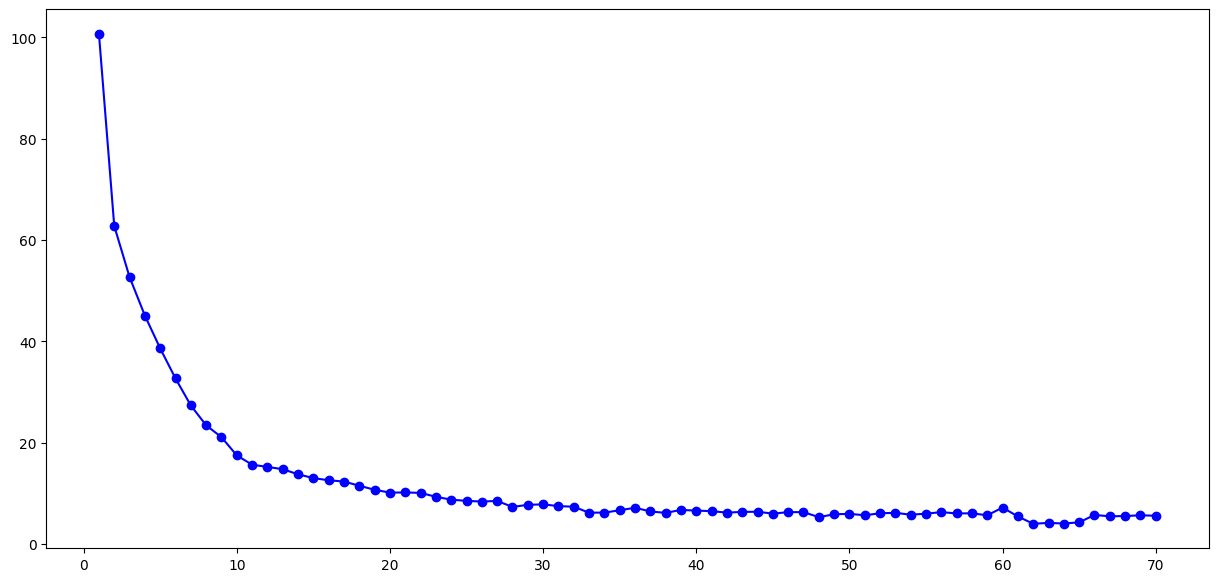

In [9]:
import matplotlib.pyplot as plt
# グラフを作成
plt.figure(figsize=(15, 7))  # グラフのサイズを設定

#plt.plot([(i + 1) * 10  for i in range(len(valid_epoch_loss))], valid_epoch_loss, marker='o', linestyle='-', color='r', label = 'Validation_loss')
plt.plot([i + 1  for i in range(len(epoch_loss))], epoch_loss, marker='o', linestyle='-', color='b', label = 'Training_loss')
plt.plot([i + 1  for i in range(len(valid_epoch_loss))], epoch_loss, marker='o', linestyle='-', color='r', label = 'Valid_loss')
# グラフにタイトルと軸ラベルを追加
plt.title('Multi Train/Valid Loss')
plt.xticks(range(0,80,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 凡例を表示
plt.legend()

# グラフを表示
plt.grid(True)  # グリッドを表示
plt.show()

In [ ]:
net = Seq2seq(event_column_size =column_length,
    mlp_hidden_size1=128,
    mlp_hidden_size2 =256,
    dropout_prob  = 0.2,
    vocab_size = max_vocab_size,
    comment_input_size = 128,
    hidden_size = 200,
    attention_size = 128).to(device)
net.load_state_dict(torch.load('/home/tanaka/Archive/NN_model/MLP-70.model'))

<All keys matched successfully>

In [ ]:
def shorten_for_rouge(encoded_list):
    prediction = []
    
    encoded_list = encoded_list[1:]
    for i in encoded_list:
        if i == 3:
            break
        else:
            prediction.append(i)
    return prediction

In [ ]:
import datasets
metric = datasets.load_metric('rouge')
tokenizer2 = CommentTokenizer(vocab_size=1128, max_length = max_length)
tokenizer2.build_vocab(df['comment_golden'])
sid = tokenizer.word2id("<s>")
eid = tokenizer.word2id("</s>")
net.eval()
k = 1
with torch.no_grad():
    for event_key in df_test:
        df_event = df[(df["試合ID"] == event_key[0]) & (df["攻撃履歴No"] == event_key[1])]
        comment = df_event['comment'].iloc[0]
        golden = df_event['comment_golden'].iloc[0]
        
        events = df_event.drop(columns = drop_columns)
        x = []
        for i in range(len(events)):
            event = torch.Tensor(events.iloc[i,:]).to(device)
            event = net.encoder.fc1(event)
            event = net.encoder.relu(event)
            event = net.encoder.dropout(event)
            event = net.encoder.relu(net.encoder.fc2(event))
            event = net.encoder.dropout(event)
            mlp_output = net.encoder.fc3(event)
            
            x.append(mlp_output)#x= [[event1][event2]...[eventn]]という感じになっていてほしい
                
        x = torch.cat(x, dim = 0)
        x = x.reshape(1,-1, net.decoder.comment_input_size)
        ox, hidden = net.encoder.lstm1(x)
        hidden1 = tuple(h.view(2,1,-1) for h in hidden)
        wid = [sid]
        s1 = 0
        print(f'\n試合ID：{event_key[0]}, 攻撃履歴ID：{event_key[1]}')
        print(f'{k}個目の生成文(generated comment)')
        k += 1
        rouge_prediction = []
        while True:
            wids = torch.LongTensor([wid]).to(device)
            y = net.decoder.comment_embedding(wids)
            oy, hidden2 = net.decoder.lstm2(y, hidden1)
            hidden1 = hidden2
            att1 = net.decoder.attention.encoder_att(ox)
            att2 = net.decoder.attention.decoder_att(oy)
            att = net.decoder.attention.full_att(net.decoder.attention.relu(att1 + att2)).squeeze(2)
            att = att/ math.sqrt(len(att[0]))
            alpha = att.softmax(dim = 1)
            
            ct = torch.bmm(alpha.unsqueeze(0), ox)
            oy1 = torch.cat([ct, oy], dim =2)
            oy2 = net.decoder.Wc(oy1)
            oy3 = net.decoder.W(oy2)
            oy3 = oy3.reshape(-1,net.decoder.vocab_size)
            wid_next_number = oy3.argmax(1).item()
            wid = [wid_next_number]
            
            
            if (wid_next_number == eid):
                break
                
            elif tokenizer.id2word(wid_next_number) == 'team':
                j_alpha = alpha[:, 0]
                j_alpha = torch.squeeze(j_alpha)
                related_event_idx = torch.argmax(j_alpha)  
                related_team = df_event.iloc[related_event_idx.item(),:]
                related_team_name = related_team['チーム名']
                print(related_team_name, " ", end ='')
                rouge_prediction.append(related_team_name)
            
            elif 'player' in tokenizer.id2word(wid_next_number) :
                
                j_alpha = alpha[:, 0]
                j_alpha = torch.squeeze(j_alpha)
                related_event_idx = torch.argmax(j_alpha)  
                related_player = df_event.iloc[related_event_idx.item(),:]
                related_player_name = related_player['選手名']
                print(related_player_name, end ='')
                rouge_prediction.append(related_player_name)
            else :
                print(tokenizer.id2word(wid_next_number), end ='')
                rouge_prediction.append(tokenizer.id2word(wid_next_number))
                
            s1 += 1
            if (s1 == max_length):
                break
            
        
        #print(f'\n{k-1}個目の答え\n{tokenizer.decode(comment[1:])}')
        print(f'\n{k-1}個目の答え(untagged reference)\n{golden}')
        pre = ''.join(rouge_prediction)
        pre = tokenizer2.encode(pre).tolist()
        golden = tokenizer2.encode(golden).tolist()
        pre = shorten_for_rouge(pre)
        golden = shorten_for_rouge(golden)
        metric.add(predictions= pre, references= golden)
        
records1 = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]   
final_score = metric.compute()
rouge_dict = dict((rn, final_score[rn].mid.fmeasure) for rn in rouge_names)
records1.append(rouge_dict)
print(records1)


試合ID：2021040301, 攻撃履歴ID：109
1個目の生成文(generated comment)
湘南  キッカーは名古が務める。名古はＤＦにはじかれてしまうが、<pad>は<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
1個目の答え(untagged reference)
湘南　ＦＫのキッカーの名古が右足を振り抜く。だが、相手の壁に防がれてしまう

試合ID：2021040307, 攻撃履歴ID：181
2個目の生成文(generated comment)
鹿島  沖が左サイドの敵陣中央から右足でグラウンダーのクロスを入れる。、ＤＦにクリアされてしまう
2個目の答え(untagged reference)
鹿島　エヴェラウドがパスを受けると、フィジカルの強さを生かしてキープし、前を向く。そのまま持ち込んでペナルティエリア手前の中央からシュートを放つも、槙野にブロックされてしまう

試合ID：2021040701, 攻撃履歴ID：202
3個目の生成文(generated comment)
鹿島  右ＣＫを獲得する。キッカーは永戸。右足でクロスを入れるも、相手にクリアされてしまう
3個目の答え(untagged reference)
鹿島　右ＣＫを獲得すると、キッカーは永戸。左足で低い弾道のクロスを入れるも、味方は触れない

試合ID：2021041109, 攻撃履歴ID：102
4個目の生成文(generated comment)
神戸  藤本が自陣から前線に浮き球のボールを送る。反応した藤本が抜け出すも、オフサイドの判定となってしまう
4個目の答え(untagged reference)
神戸　